# NLP Analysis of WiMLDS Event Titles

### Date
19-May-2019

### Reference
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Import Packages
The core packages used in this tutorial are `re`, `gensim`, `spacy` and `pyLDAvis`. Besides this we will also using `matplotlib`, `numpy` and `pandas` for data handling and visualization. Let’s import them.

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime
    
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import sys
print("Python Version:", sys.version)

Python Version: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import matplotlib

In [4]:
matplotlib.__version__

'2.2.2'

In [5]:
pd.__version__

'0.23.0'

In [6]:
df_events = pd.read_csv('wimlds_events_2019_05_08.csv')

In [7]:
len(df_events)

439

In [8]:
list(df_events)

['chapter_name', 'link', 'local_date', 'name', 'yes_rsvp_count']

In [9]:
len(df_events.chapter_name.unique())

43

In [10]:
df_events.local_date.min()

'1/10/19'

In [11]:
df_events.local_date.max()

'9/8/18'

In [12]:
df_events['event_date'] =  pd.to_datetime(df_events['local_date'], format='%x')

In [13]:
df_events.event_date.min()

Timestamp('2014-01-23 00:00:00')

In [15]:
df_events.event_date.max()

Timestamp('2019-05-07 00:00:00')

In [16]:
df_events.head(10)

,chapter_name,link,local_date,name,yes_rsvp_count,event_date
0,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,3/10/18,Big Data: From Chaos to Intelligence,17,2018-03-10
1,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,5/5/18,Machine Learning: A Focus on Supervised and Un...,35,2018-05-05
2,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,7/21/18,Deep Learning: Build An Image Classification M...,20,2018-07-21
3,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,6/24/17,NLP: Zero to one,59,2017-06-24
4,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,8/5/17,Handling Imbalanced Datasets: Building a model...,63,2017-08-05
5,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,11/25/17,The ABC-XYZ of Data Science before Machine Lea...,50,2017-11-25
6,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,12/8/16,Uncovering patterns and trends using explorato...,17,2016-12-08
7,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,1/28/17,Extracting Your Own Web Data using Scraping Tools,8,2017-01-28
8,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,2/25/17,TensorFlow Post-Summit Event,95,2017-02-25
9,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,3/25/17,Fueling the Artificial Intelligence revolution...,35,2017-03-25


In [18]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [19]:
# Convert to list
data = df_events.name.values.tolist()

In [20]:
data

['Big Data: From Chaos to Intelligence',
 'Machine Learning: A Focus on Supervised and Unsupervised Learning',
 'Deep Learning: Build An Image Classification Model',
 'NLP: Zero to one',
 'Handling Imbalanced Datasets: Building a model and deploying to production',
 'The ABC-XYZ of Data Science before Machine Learning',
 'Uncovering patterns and trends using exploratory data analysis',
 'Extracting Your Own Web Data using Scraping Tools',
 'TensorFlow Post-Summit Event',
 'Fueling the Artificial Intelligence revolution with gaming!',
 'Sentiment Analysis in R',
 'Unravelling Intel Deep Learning SDK',
 'TensorFlow : Zero to One',
 'Treasure Island: Bioinformatics for everyone.',
 'Deep Learning for Crypt-analysis using TensorFlow',
 'Prototyping Back Propagation in Excel For Greater Good',
 'Data Science and Machine Learning in Practice',
 '#NairobiWiMLDS turns 1 + Christmas Party',
 'Around the world of data science in 60 minutes or less',
 'TensorFlow Series: Convolutional Neural Netw

In [22]:
len(data)

439

## Tokenize words and Clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s `simple_preprocess()` is great for this. Additionally I have set `deacc=True` to remove the punctuations.

In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:3])

[['big', 'data', 'from', 'chaos', 'to', 'intelligence'], ['machine', 'learning', 'focus', 'on', 'supervised', 'and', 'unsupervised', 'learning'], ['deep', 'learning', 'build', 'an', 'image', 'classification', 'model']]


## Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s `Phrases` model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to `Phrases` are `min_count` and `threshold`. The higher the values of these param, the harder it is for words to be combined to bigrams.



In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=15) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=15)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

['the', 'abc', 'xyz', 'of', 'data_science', 'before', 'machine_learning']


/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [25]:
print([bigram_mod[data_words[5]]])

[['the', 'abc', 'xyz', 'of', 'data_science', 'before', 'machine_learning']]


## Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.



In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Let's call the functions in order

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [28]:
print(data_lemmatized[:2])

[['big', 'datum', 'chaos', 'intelligence'], ['machine_learn', 'focus', 'supervise', 'unsupervised', 'learning']]


## 11. Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary (`id2word`) and the corpus. Let’s create them.

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
pprint(corpus[:20])

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
 [(14, 1)],
 [(13, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [(6, 1), (21, 1)],
 [(2, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(2, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(32, 1), (33, 1), (34, 1), (35, 1)],
 [(36, 1), (37, 1), (38, 1), (39, 1)],
 [(22, 1), (40, 1)],
 [(11, 1), (41, 1), (42, 1), (43, 1)],
 [(35, 1)],
 [(44, 1), (45, 1), (46, 1), (47, 1)],
 [(11, 1), (22, 1), (27, 1), (35, 1), (48, 1)],
 [(49, 1), (50, 1), (51, 1), (52, 1), (53, 1)],
 [(6, 1), (21, 1), (54, 1)],
 [(55, 1), (56, 1), (57, 1), (58, 1)],
 [(21, 1), (59, 1), (60, 1), (61, 1)],
 [(10, 1), (12, 1), (35, 1), (62, 1), (63, 1), (64, 1), (65, 1)]]


In [118]:
len(id2word)

750

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [30]:
id2word[0]

'big'

In [31]:
id2word[5]

'learning'

In [32]:
id2word[1]

'chaos'

In [33]:
id2word[4]

'focus'

Or, you can see a human-readable form of the corpus itself.

In [34]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('big', 1), ('chaos', 1), ('datum', 1), ('intelligence', 1)]]

## 12. Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, `alpha` and `eta` are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

`chunksize` is the number of documents to be used in each training chunk. `update_every` determines how often the model parameters should be updated and `passes` is the total number of training passes.

In [35]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## 13. View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using `lda_model.print_topics()` as shown next.

In [36]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(8,
  '0.035*"tea" + 0.035*"syndrome" + 0.035*"sunday" + 0.035*"morning" + '
  '0.035*"imposter" + 0.035*"conquer" + 0.035*"predictability" + 0.035*"drink" '
  '+ 0.035*"ponder" + 0.035*"waterworks"'),
 (34,
  '0.033*"healthy" + 0.033*"decision" + 0.033*"wise" + 0.033*"personalize" + '
  '0.033*"modeling" + 0.033*"policy" + 0.033*"wealthy" + 0.033*"scalable" + '
  '0.033*"machine_learning" + 0.026*"mlcc"'),
 (36,
  '0.073*"visualization" + 0.051*"lingual" + 0.039*"understanding" + '
  '0.026*"multi" + 0.026*"board" + 0.026*"mono" + 0.026*"context" + '
  '0.026*"language" + 0.026*"scale" + 0.026*"formation"'),
 (32,
  '0.056*"learning" + 0.040*"interactive" + 0.040*"real" + 0.016*"core" + '
  '0.016*"unsupervised" + 0.016*"wids_pune" + 0.016*"join" + '
  '0.016*"invitation" + 0.016*"casbon" + 0.016*"text"'),
 (22,
  '0.106*"informal" + 0.106*"reuni" + 0.045*"tom" + 0.035*"conference" + '
  '0.029*"initiative" + 0.023*"festival" + 0.023*"founder" + '
  '0.013*"production" + 0.013*"build

## 14. Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.969351531748332

Coherence Score:  0.45422719515524806


## 15. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.096065  0.255399       1        1  7.622030
23     0.336549 -0.117756       2        1  5.255936
38     0.049904  0.142308       3        1  4.756356
24     0.260669 -0.091090       4        1  4.319355
3      0.054098 -0.033979       5        1  3.964429
21     0.054480  0.159581       6        1  3.570305
17     0.006680  0.056189       7        1  3.424819
35    -0.019913  0.101606       8        1  3.293081
37    -0.009393  0.022043       9        1  3.255469
39    -0.035228 -0.012631      10        1  3.253993
18    -0.032797 -0.015063      11        1  2.950770
11    -0.007667  0.023374      12        1  2.846996
26    -0.035497  0.046291      13        1  2.703936
31     0.144985 -0.030138      14        1  2.699034
5      0.013956  0.080755      15        1  2.644545
20     0.100894 -0.054050      16        1  2.446245
7     -0.040605 -0.022136      17        1  2.446212
13    -0.023148  0.024775      18        1  2.404853
4     -0.034353 -0.019919      19        1  2.293498
25     0.024579  0.154568      20        1  2.268907
29    -0.041045 -0.022907      21        1  2.218329
14    -0.014762 -0.022532      22        1  2.154802
0     -0.026552 -0.003105      23        1  2.035573
19    -0.045842 -0.028436      24        1  1.995049
12    -0.043512 -0.025609      25        1  1.970904
28    -0.036989 -0.049231      26        1  1.886233
27    -0.051546 -0.035147      27        1  1.825886
9     -0.049455 -0.034089      28        1  1.705843
15    -0.047301 -0.031710      29        1  1.682505
30    -0.053619 -0.038864      30        1  1.575970
1     -0.039215 -0.021433      31        1  1.542927
2     -0.044596 -0.027604      32        1  1.462767
10    -0.047183 -0.029102      33        1  1.410333
16    -0.053990 -0.039629      34        1  1.349845
33    -0.049765 -0.037523      35        1  1.296355
34    -0.057116 -0.042075      36        1  1.289195
22    -0.030410 -0.051445      37        1  1.194595
36    -0.056019 -0.042304      38        1  1.128266
32    -0.058744 -0.045588      39        1  0.957803
8     -0.056596 -0.041794      40        1  0.896056, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
21    Default  53.000000      data_science  53.000000  30.0000  30.0000
69    Default  48.000000              code  48.000000  29.0000  29.0000
6     Default  33.000000     machine_learn  33.000000  28.0000  28.0000
111   Default  30.000000             wimld  30.000000  27.0000  27.0000
137   Default  32.000000             woman  32.000000  26.0000  26.0000
2     Default  27.000000             datum  27.000000  25.0000  25.0000
32    Default  18.000000             event  18.000000  24.0000  24.0000
91    Default  19.000000                ai  19.000000  23.0000  23.0000
118   Default  15.000000          workshop  15.000000  22.0000  22.0000
135   Default  12.000000               day  12.000000  21.0000  21.0000
99    Default  13.000000            meetup  13.000000  20.0000  20.0000
100   Default  13.000000            python  13.000000  19.0000  19.0000
365   Default  17.000000               bay  17.000000  18.0000  18.0000
366   Default  17.000000       coffee_east  17.000000  17.0000  17.0000
320   Default   9.000000              talk   9.000000  16.0000  16.0000
298   Default  11.000000             share  11.000000  15.0000  15.0000
325   Default   9.000000             night   9.000000  14.0000  14.0000
375   Default   9.000000             intro   9.000000  13.0000  13.0000
27    Default   8.000000               use   8.000000  12.0000  12.0000
66    Default  13.000000        conference  13.000000  11.0000  11.0000
297   Default   7.000000        happy_hour   7.000000  10.0000  10.0000
418   Default   7.000000             learn   7.000000   9.0000   9.0000
371

## Try 10 topics

In [39]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.085*"wimld" + 0.081*"meetup" + 0.039*"talk" + 0.037*"tech" + '
  '0.027*"community" + 0.024*"road" + 0.024*"trip" + 0.024*"processing" + '
  '0.020*"happy_hour" + 0.016*"fireside"'),
 (1,
  '0.051*"intro" + 0.041*"fast" + 0.024*"analytic" + 0.021*"digital" + '
  '0.021*"fire" + 0.019*"winter" + 0.018*"spark" + 0.017*"humanity" + '
  '0.017*"teach" + 0.017*"informal"'),
 (2,
  '0.178*"code" + 0.065*"coffee_east" + 0.065*"bay" + 0.045*"coffee_peninsula" '
  '+ 0.043*"night" + 0.036*"coffee_sf" + 0.033*"coffee" + 0.030*"datum" + '
  '0.022*"demo" + 0.018*"graph"'),
 (3,
  '0.096*"event" + 0.076*"datum" + 0.039*"lady" + 0.037*"social" + '
  '0.030*"artificial_intelligence" + 0.027*"world" + 0.023*"dinner" + '
  '0.021*"partner" + 0.018*"special" + 0.017*"networking"'),
 (4,
  '0.154*"machine_learn" + 0.114*"data_science" + 0.056*"woman" + '
  '0.037*"learn" + 0.023*"conference_screen" + 0.023*"health" + 0.023*"art" + '
  '0.020*"spotify" + 0.016*"herramienta" + 0.016*"user"'),
 (

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.810941763130646

Coherence Score:  0.5464389452310937


In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.074053 -0.152363       1        1  13.306159
0     -0.147178  0.009189       2        1  12.239175
6      0.237028 -0.014127       3        1  11.259828
3     -0.099486 -0.125005       4        1  10.088161
8     -0.037094  0.200098       5        1   9.576323
4      0.179197 -0.009152       6        1   9.506629
7     -0.062541  0.053674       7        1   9.238016
9     -0.012323  0.137558       8        1   9.039350
5      0.057854 -0.091067       9        1   8.359199
1     -0.041404 -0.008805      10        1   7.387164, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
69    Default  42.000000              code  42.000000  30.0000  30.0000
6     Default  31.000000     machine_learn  31.000000  29.0000  29.0000
21    Default  46.000000      data_science  46.000000  28.0000  28.0000
137   Default  28.000000             woman  28.000000  27.0000  27.0000
118   Default  17.000000          workshop  17.000000  26.0000  26.0000
32    Default  17.000000             event  17.000000  25.0000  25.0000
99    Default  18.000000            meetup  18.000000  24.0000  24.0000
2     Default  28.000000             datum  28.000000  23.0000  23.0000
111   Default  24.000000             wimld  24.000000  22.0000  22.0000
366   Default  15.000000       coffee_east  15.000000  21.0000  21.0000
365   Default  15.000000               bay  15.000000  20.0000  20.0000
91    Default  22.000000                ai  22.000000  19.0000  19.0000
135   Default  14.000000               day  14.000000  18.0000  18.0000
66    Default  10.000000        conference  10.000000  17.0000  17.0000
298   Default   9.000000             share   9.000000  16.0000  16.0000
100   Default  12.000000            python  12.000000  15.0000  15.0000
371   Default  11.000000  coffee_peninsula  11.000000  14.0000  14.0000
325   Default  10.000000             night  10.000000  13.0000  13.0000
375   Default   7.000000             intro   7.000000  12.0000  12.0000
112   Default   7.000000     deep_learning   7.000000  11.0000  11.0000
320   Default   9.000000              talk   9.000000  10.0000  10.0000
224   Default   7.000000           kickoff   7.000000   9.0000   9.0000
364   Default   9.000000         coffee_sf   9.000000   8.0000   8.0000
368   Default   8.000000              tech   8.000000   7.0000   7.0000
11    Default   7.000000        deep_learn   7.000000   6.0000   6.0000
232   Default   7.000000              lady   7.000000   5.0000   5.0000
282   Default   7.000000            social   7.000000   4.0000   4.0000
355   Default   8.000000            coffee   8.000000   3.0000   3.0000
418   Default   6.000000             learn   6.000000   2.0000   2.0000
221   Default   5.000000              fast   5.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
221   Topic10   5.378489              fast   5.991702   2.4975  -3.2021
218   Topic10   3.143411          analytic   3.756389   2.4273  -3.7392
410   Topic10   2.741462              fire   3.354376   2.4037  -3.8761
403   Topic10   2.427317             spark   3.040219   2.3803  -3.9978
767   Topic10   2.275952             teach   2.888847   2.3670  -4.0621
718   Topic10   2.275952             reuni   2.888847   2.3670  -4.0621
766   Topic10   2.275952           promote   2.888847   2.3670  -4.0621
717   Topic10   2.275952          informal   2.888847   2.3670  -4.0621
763   Topic10   2.275952          humanity   2.888847   2.3670  -4.0621
764   Topic10   2.275952        literature   2.888847   2.3670  -4.0621
765   Topic10   2.275952          metadata   2.888847   2.3670  -4.0621
697   Topic10   2.275912             rapid   2.888850   2.3669  -4.0622
50    Topic10   2.260996              good   2.873948   2.3655  -4.06

## Try 25 topics

In [43]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [44]:
# Print the Keyword in the 25 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(12,
  '0.033*"center" + 0.024*"ai" + 0.017*"ceo" + 0.017*"company" + '
  '0.017*"female" + 0.017*"measure" + 0.017*"explore" + 0.017*"bayesian" + '
  '0.017*"conquer" + 0.017*"inference"'),
 (21,
  '0.043*"job" + 0.041*"research" + 0.036*"visualization" + 0.031*"high" + '
  '0.025*"lingual" + 0.019*"understanding" + 0.017*"forward" + '
  '0.017*"pictalhealth" + 0.017*"mccurdy" + 0.017*"katie"'),
 (13,
  '0.068*"model" + 0.068*"artificial" + 0.053*"carrera" + 0.053*"haciendo" + '
  '0.053*"inteligencia" + 0.027*"feature" + 0.026*"ibm" + 0.021*"create" + '
  '0.021*"developer" + 0.017*"speaker"'),
 (1,
  '0.141*"practical" + 0.049*"tip" + 0.026*"round" + 0.026*"datathon" + '
  '0.025*"next" + 0.018*"vt" + 0.018*"random" + 0.018*"forest" + '
  '0.014*"resume" + 0.014*"challenge"'),
 (2,
  '0.129*"intro" + 0.050*"pytorch" + 0.043*"humanity" + 0.043*"teach" + '
  '0.043*"literature" + 0.043*"promote" + 0.043*"metadata" + 0.043*"con" + '
  '0.025*"course" + 0.025*"part"'),
 (16,
  '0.066*"

In [45]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.954352705084911

Coherence Score:  0.48863791905952275


In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.328437 -0.031572       1        1  8.977602
0      0.005731  0.271543       2        1  8.765195
17     0.039151  0.072848       3        1  5.450473
18     0.064265 -0.080185       4        1  5.403542
7     -0.106741 -0.008453       5        1  5.373542
24     0.072161 -0.168664       6        1  5.346608
22     0.069861 -0.112040       7        1  5.068671
6     -0.006051  0.036562       8        1  4.782187
15    -0.144135 -0.035017       9        1  4.227639
5      0.010369  0.084384      10        1  4.010640
23     0.034207  0.029558      11        1  3.999350
20     0.059260 -0.061778      12        1  3.873444
4      0.039298  0.010824      13        1  3.638505
10     0.032772  0.062807      14        1  3.375226
3      0.019274 -0.008957      15        1  2.977635
8      0.032489  0.017617      16        1  2.732756
14     0.028937  0.025550      17        1  2.684692
21     0.035433 -0.003311      18        1  2.649896
19    -0.192566 -0.034612      19        1  2.574361
9      0.055322 -0.067619      20        1  2.530783
12     0.042484  0.003150      21        1  2.476740
2      0.028993  0.005669      22        1  2.458611
16     0.037522 -0.006564      23        1  2.376575
13     0.035234  0.000581      24        1  2.302637
1      0.035170 -0.002322      25        1  1.942687, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
69    Default  46.000000              code  46.000000  30.0000  30.0000
137   Default  37.000000             woman  37.000000  29.0000  29.0000
6     Default  35.000000     machine_learn  35.000000  28.0000  28.0000
21    Default  51.000000      data_science  51.000000  27.0000  27.0000
111   Default  27.000000             wimld  27.000000  26.0000  26.0000
2     Default  29.000000             datum  29.000000  25.0000  25.0000
99    Default  23.000000            meetup  23.000000  24.0000  24.0000
32    Default  18.000000             event  18.000000  23.0000  23.0000
91    Default  18.000000                ai  18.000000  22.0000  22.0000
118   Default  15.000000          workshop  15.000000  21.0000  21.0000
365   Default  17.000000               bay  17.000000  20.0000  20.0000
366   Default  17.000000       coffee_east  17.000000  19.0000  19.0000
100   Default  13.000000            python  13.000000  18.0000  18.0000
135   Default  11.000000               day  11.000000  17.0000  17.0000
298   Default   8.000000             share   8.000000  16.0000  16.0000
320   Default   8.000000              talk   8.000000  15.0000  15.0000
371   Default  12.000000  coffee_peninsula  12.000000  14.0000  14.0000
368   Default   9.000000              tech   9.000000  13.0000  13.0000
224   Default   7.000000           kickoff   7.000000  12.0000  12.0000
66    Default  14.000000        conference  14.000000  11.0000  11.0000
418   Default   7.000000             learn   7.000000  10.0000  10.0000
375   Default   6.000000             intro   6.000000   9.0000   9.0000
282   Default   6.000000            social   6.000000   8.0000   8.0000
297   Default   6.000000        happy_hour   6.000000   7.0000   7.0000
522   Default   5.000000         practical   5.000000   6.0000   6.0000
57    Default   7.000000             party   7.000000   5.0000   5.0000
676   Default   8.000000         community   8.000000   4.0000   4.0000
11    Default   7.000000        deep_learn   7.000000   3.0000   3.0000
112   Default   5.000000     deep_learning   5.000000   2.0000   2.0000
68    Default   7.000000               wid   7.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
428   Topic25   0.920692             round   1.554223   3.4175  -3.6315
98    Topic25   0.876403              next   1.509935   3.3971  -3.6808
639   

## 16. Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [47]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [48]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8,
  [('workshop', 0.24705882352941178),
   ('hand', 0.09411764705882353),
   ('introduction', 0.08235294117647059),
   ('tensorflow', 0.08235294117647059),
   ('practical', 0.03529411764705882),
   ('deep_learn', 0.023529411764705882),
   ('unplugged', 0.023529411764705882),
   ('job', 0.023529411764705882),
   ('wise', 0.011764705882352941),
   ('corpus', 0.011764705882352941)]),
 (12,
  [('wimld', 0.35353535353535354),
   ('apply', 0.030303030303030304),
   ('graph', 0.030303030303030304),
   ('change', 0.030303030303030304),
   ('triangle', 0.030303030303030304),
   ('robotic', 0.020202020202020204),
   ('christma', 0.020202020202020204),
   ('step', 0.020202020202020204),
   ('definition', 0.020202020202020204),
   ('nlp', 0.020202020202020204)]),
 (13,
  [('datum', 0.11538461538461539),
   ('python', 0.10256410256410256),
   ('networking', 0.0641025641025641),
   ('happy_hour', 0.0641025641025641),
   ('ibm', 0.05128205128205128),
   ('intro', 0.05128205128205128),
   ('applica

## 17. How to find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [50]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

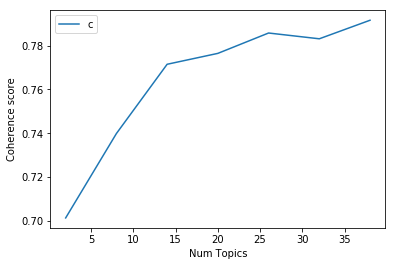

In [51]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7012
Num Topics = 8  has Coherence Value of 0.7398
Num Topics = 14  has Coherence Value of 0.7715
Num Topics = 20  has Coherence Value of 0.7765
Num Topics = 26  has Coherence Value of 0.7859
Num Topics = 32  has Coherence Value of 0.7832
Num Topics = 38  has Coherence Value of 0.7917


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with **20 topics** itself.

In [54]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(25,
  '0.347*"bay" + 0.250*"coffee_east" + 0.083*"introduction" + 0.028*"lecture" '
  '+ 0.014*"speaker" + 0.014*"lab" + 0.014*"dzie" + 0.014*"project" + '
  '0.014*"shetalksdata" + 0.014*"africa"'),
 (21,
  '0.125*"night" + 0.078*"image" + 0.047*"coffee" + 0.047*"care" + '
  '0.047*"discussion" + 0.031*"registration" + 0.031*"software" + '
  '0.031*"herramienta" + 0.031*"tea" + 0.031*"big"'),
 (22,
  '0.225*"event" + 0.070*"share" + 0.056*"kickoff" + 0.056*"partner" + '
  '0.042*"lunch" + 0.042*"nairobi" + 0.028*"wid" + 0.028*"winter" + '
  '0.028*"pdx" + 0.028*"summit"'),
 (10,
  '0.579*"code" + 0.053*"spark" + 0.026*"community" + 0.013*"edge" + '
  '0.013*"wednesday" + 0.013*"holiday" + 0.013*"kickoff" + 0.013*"thick" + '
  '0.013*"pune" + 0.013*"woman"'),
 (9,
  '0.279*"coffee_peninsula" + 0.066*"international" + 0.066*"big" + '
  '0.033*"analysis" + 0.033*"artificial" + 0.033*"kobiet" + 0.033*"good" + '
  '0.016*"hangout" + 0.016*"org" + 0.016*"definition"'),
 (4,
  '0.100*"tens

Those were the topics for the chosen LDA model.

## 18. Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [55]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.0541,"day, data_science, deep_learn, party, demo, ne...",Big Data: From Chaos to Intelligence
1,1,11.0,0.0572,"python, analytic, event, data_science, analysi...",Machine Learning: A Focus on Supervised and Un...
2,2,17.0,0.0572,"woman, hand, panel, build, diversity, conferen...",Deep Learning: Build An Image Classification M...
3,3,18.0,0.0530,"conference, learn, coffee, lady, theory, benga...",NLP: Zero to one
4,4,6.0,0.0493,"woman, data_science, conference, building, vis...",Handling Imbalanced Datasets: Building a model...
5,5,23.0,0.0519,"data_science, triangle, datathon, machine_lear...",The ABC-XYZ of Data Science before Machine Lea...
6,6,9.0,0.0562,"coffee_peninsula, international, big, analysis...",Uncovering patterns and trends using explorato...
7,7,2.0,0.0653,"wimld, coffee_east, work, network, world, mash...",Extracting Your Own Web Data using Scraping Tools
8,8,22.0,0.0665,"event, share, kickoff, partner, lunch, nairobi...",TensorFlow Post-Summit Event
9,9,1.0,0.0562,"machine_learn, talk, demystify, tom, neo, evol...",Fueling the Artificial Intelligence revolution...


## 19. Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [56]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(25)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0805,"tech, artificial_intelligence, networking, app...","Data science in high-tech manufacturing, agric..."
1,1.0,0.0825,"machine_learn, talk, demystify, tom, neo, evol...",Applied Machine Learning Conference (Tom Tom F...
2,2.0,0.0706,"wimld, coffee_east, work, network, world, mash...",Sector Mash Meetup from #CodeforBTV
3,3.0,0.0753,"day, data_science, deep_learn, party, demo, ne...",Women's day special with Spotify on user perso...
4,4.0,0.0760,"tensorflow, workshop, pyladie, classification,...",Traffic Lights Detection using Tensorflow - On...
5,5.0,0.0635,"machine_learn, technology, kick, modern, appne...",Data Science and Machine Learning in Practice
6,6.0,0.0657,"woman, data_science, conference, building, vis...",WiMLDS / Women in Data Science International W...
7,7.0,0.0665,"wimld, happy_hour, talk, apache, champlain, wi...",Generative Art Talk at Champlain
8,8.0,0.0693,"meetup, graph, job, series, session, nairobiwi...",Statistical Challenges in Oncology at Flatiron...
9,9.0,0.0684,"coffee_peninsula, international, big, analysis...",Spotkanie Networkingowe DATA SCIENCE - Dzie≈Ñ ...


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

## 20. Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [57]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"day, data_science, deep_learn, party, demo, ne...",23.0,0.0524
1,11.0,"python, analytic, event, data_science, analysi...",9.0,0.0205
2,17.0,"woman, hand, panel, build, diversity, conferen...",10.0,0.0228
3,18.0,"conference, learn, coffee, lady, theory, benga...",19.0,0.0433
4,6.0,"woman, data_science, conference, building, vis...",14.0,0.0319
5,23.0,"data_science, triangle, datathon, machine_lear...",13.0,0.0296
6,9.0,"coffee_peninsula, international, big, analysis...",21.0,0.0478
7,2.0,"wimld, coffee_east, work, network, world, mash...",13.0,0.0296
8,22.0,"event, share, kickoff, partner, lunch, nairobi...",28.0,0.0638
9,1.0,"machine_learn, talk, demystify, tom, neo, evol...",28.0,0.0638


## 21. Conclusion
We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.

Edit: I see some of you are experiencing errors while using the LDA Mallet and I don’t have a solution for some of the issues. So, I’ve implemented a workaround and more useful topic model visualizations. Hope you will find it helpful.

---

# Topic modeling visualization – How to present the results of LDA models?

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

Updated:  29-May-2019


## 1. Introduction
In topic modeling with gensim, we followed a structured workflow to build an insightful topic model based on the Latent Dirichlet Allocation (LDA) algorithm.

In this post, we will build the topic model using gensim’s native LdaModel and explore multiple strategies to effectively visualize the results using matplotlib plots.

I will be using a portion of the 20 Newsgroups dataset since the focus is more on approaches to visualizing the results.

Let’s begin by importing the packages and the 20 News Groups dataset.

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', \
                   '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', \
                   'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', \
                   'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', \
                   'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## 2. Import NewsGroups Dataset
Let’s import the news groups dataset and retain only 4 of the target_names categories.

In [99]:
# Import Dataset
df = df_events.copy()
print(df.shape)  #> (2361, 3)
df = df.drop(["local_date", "yes_rsvp_count", "link"], axis=1)
df.head()

(439, 6)


,chapter_name,name,event_date
0,Abuja Women in Machine Learning and Data Science,Big Data: From Chaos to Intelligence,2018-03-10
1,Abuja Women in Machine Learning and Data Science,Machine Learning: A Focus on Supervised and Unsupervised Learning,2018-05-05
2,Abuja Women in Machine Learning and Data Science,Deep Learning: Build An Image Classification Model,2018-07-21
3,Lagos Women in Machine Learning & Data Science,NLP: Zero to one,2017-06-24
4,Lagos Women in Machine Learning & Data Science,Handling Imbalanced Datasets: Building a model and deploying to production,2017-08-05


## 3. Tokenize Sentences and Clean
Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [101]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.name.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', \
#'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]


[['big', 'data', 'from', 'chaos', 'to', 'intelligence']]


In [116]:
len(data)

439

## 4. Build the Bigram, Trigram Models and Lemmatize
Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [ ]:
# change threshold below from 100 to 15

In [102]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=15) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=15)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a f

## 5. Build the Topic Model
To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

*Example:*  If you examine the topic key words, they are nicely segregate and collectively represent the topics we initially chose: Christianity, Hockey, MidEast and Motorcycles. Nice!

In [141]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(22,
  '0.374*"data_science" + 0.141*"meetup" + 0.131*"python" + 0.052*"world" + '
  '0.046*"herramienta" + 0.022*"para" + 0.019*"introducci" + 0.019*"tall" + '
  '0.012*"jpmorgan" + 0.012*"chase"'),
 (17,
  '0.221*"workshop" + 0.082*"learn" + 0.061*"traffic" + 0.061*"light" + '
  '0.061*"onsite" + 0.050*"lunch" + 0.043*"pytorch" + 0.041*"con" + '
  '0.038*"submit" + 0.011*"pyspark"'),
 (5,
  '0.054*"target" + 0.053*"host" + 0.053*"pittsburgh" + 0.034*"bingo" + '
  '0.034*"buzzword" + 0.034*"graphhack" + 0.029*"lingual" + 0.015*"language" + '
  '0.015*"mono" + 0.015*"scale"'),
 (1,
  '0.056*"business" + 0.050*"problem" + 0.050*"goal" + 0.041*"set" + '
  '0.041*"tea" + 0.041*"vallera" + 0.041*"randall" + 0.041*"julia" + '
  '0.041*"harp" + 0.041*"reckless"'),
 (8,
  '0.176*"code" + 0.062*"coffee" + 0.052*"coffee_east_bay" + 0.046*"informal" '
  '+ 0.046*"reuni" + 0.046*"broderick" + 0.046*"nos" + 0.046*"visita" + '
  '0.046*"tamara" + 0.046*"primer"'),
 (7,
  '0.091*"practical" + 0.084

## 6. What is the Dominant topic and its percentage contribution in each document
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [150]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
len(df_dominant_topic)


439

In [151]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,20.0,0.6078,"big, visualization, enigma, software, job, picture, measure, quality, cloudera, success","[big, datum, chaos, intelligence]"
1,1,10.0,0.8400,"machine_learn, share, tech, community, health, diversity, art, work, care, spotify","[machine_learn, focus, supervise, unsupervised, learning]"
2,2,7.0,0.8400,"practical, school, portland, coder, deep_learn, build, user, personalisation, series, neural","[deep_learn, build, image, classification, model]"
3,3,13.0,0.5200,"intro, detection, network, kick, meeting, organiser, literature, teach, promote, humanity",[nlp]
4,4,5.0,0.7549,"target, host, pittsburgh, bingo, buzzword, graphhack, lingual, language, mono, scale","[handle, imbalanced, dataset, building, model, deploy, production]"
5,5,10.0,0.3467,"machine_learn, share, tech, community, health, diversity, art, work, care, spotify","[data_science, machine_learn]"
6,6,9.0,0.7197,"datum, fast, analytic, afternoon, dinner, spark, apache, friday, hangout, holiday","[uncover, pattern, trend, exploratory, datum, analysis]"
7,7,1.0,0.6731,"business, problem, goal, set, tea, vallera, randall, julia, harp, reckless","[extract, web, datum, scraping, tool]"
8,8,18.0,0.8080,"event, social, partner, tensorflow, triangle, curious, trend, action, annual, analyst","[tensorflow, post, summit, event]"
9,9,5.0,0.7600,"target, host, pittsburgh, bingo, buzzword, graphhack, lingual, language, mono, scale","[fuel, revolution, gaming]"


## 7. The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic

In [152]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(25)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7822,"lightning_talk, first, proposal, cfp, fire, research, presentation, global, rapid, value","[night, lightning_talk, fire, risk, customer, value, ski, flooding]"
1,1.0,0.8400,"business, problem, goal, set, tea, vallera, randall, julia, harp, reckless","[invitation, join, core, committee, wids_pune]"
2,2.0,0.8080,"deep_learning, introduction, session, casual, mentorship, together, bias, algorithmic, ethic, fa...","[casual, together, mentorship, session]"
3,3.0,0.8400,"night, party, demo, chat, fireside, halifax, pre, movie, hack, viz","[small, group, mentor, night, unblock]"
4,4.0,0.8629,"wednesday, drink, waterworks, syndrome, wine, planet, tea, daily, sunday, imposter","[conquer, imposter, syndrome, sunday, morning, tea]"
5,5.0,0.8800,"target, host, pittsburgh, bingo, buzzword, graphhack, lingual, language, mono, scale","[markdown, czyli, wizualizacja, danych, ºnych, formatach, html]"
6,6.0,0.8400,"data, artist, mccurdy, katie, pictalhealth, public, kristen, explore, nyu, sosulski","[wizualizacja, danych, wprowadzenie, pakietu, ggplot]"
7,7.0,0.8400,"practical, school, portland, coder, deep_learn, build, user, personalisation, series, neural","[deep_learn, build, image, classification, model]"
8,8.0,0.7200,"code, coffee, coffee_east_bay, informal, reuni, broderick, nos, visita, tamara, primer","[primer, meetup, nos, visita, tamara, broderick]"
9,9.0,0.8080,"datum, fast, analytic, afternoon, dinner, spark, apache, friday, hangout, holiday","[friday, afternoon, datum, hangout]"


## 8. Frequency Distribution of Word Counts in Documents
When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

In [153]:
# changes made in below
# figsize
# xlim from 1000 to 500 (docs)
# xticks from 1000 to 500
# plt.text(750, 100, ---> 500, 100

<Figure size 1920x1120 with 0 Axes>

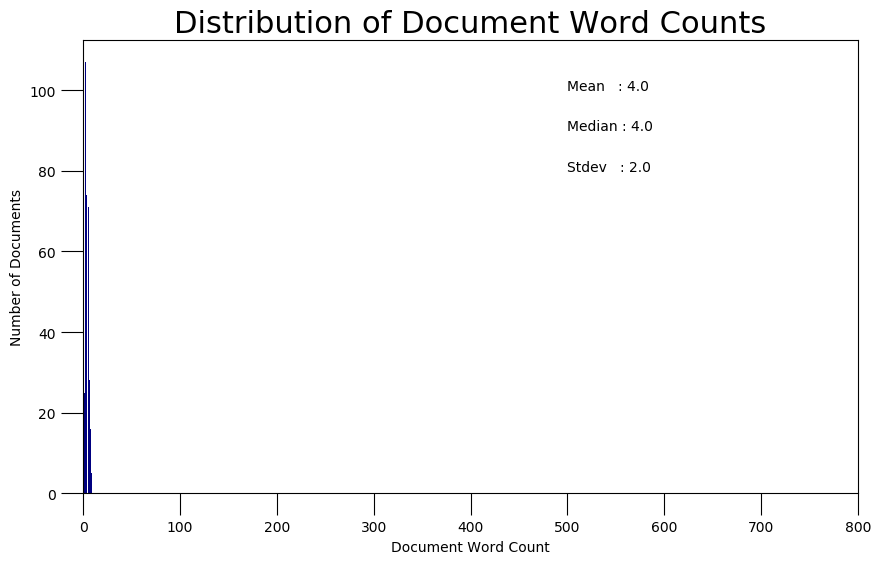

In [154]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(12,7), dpi=160)
plt.figure(figsize=(10,6), dpi=100)
plt.hist(doc_lens, bins = 10, color='navy')
plt.text(500, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(500,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(500,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,800,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

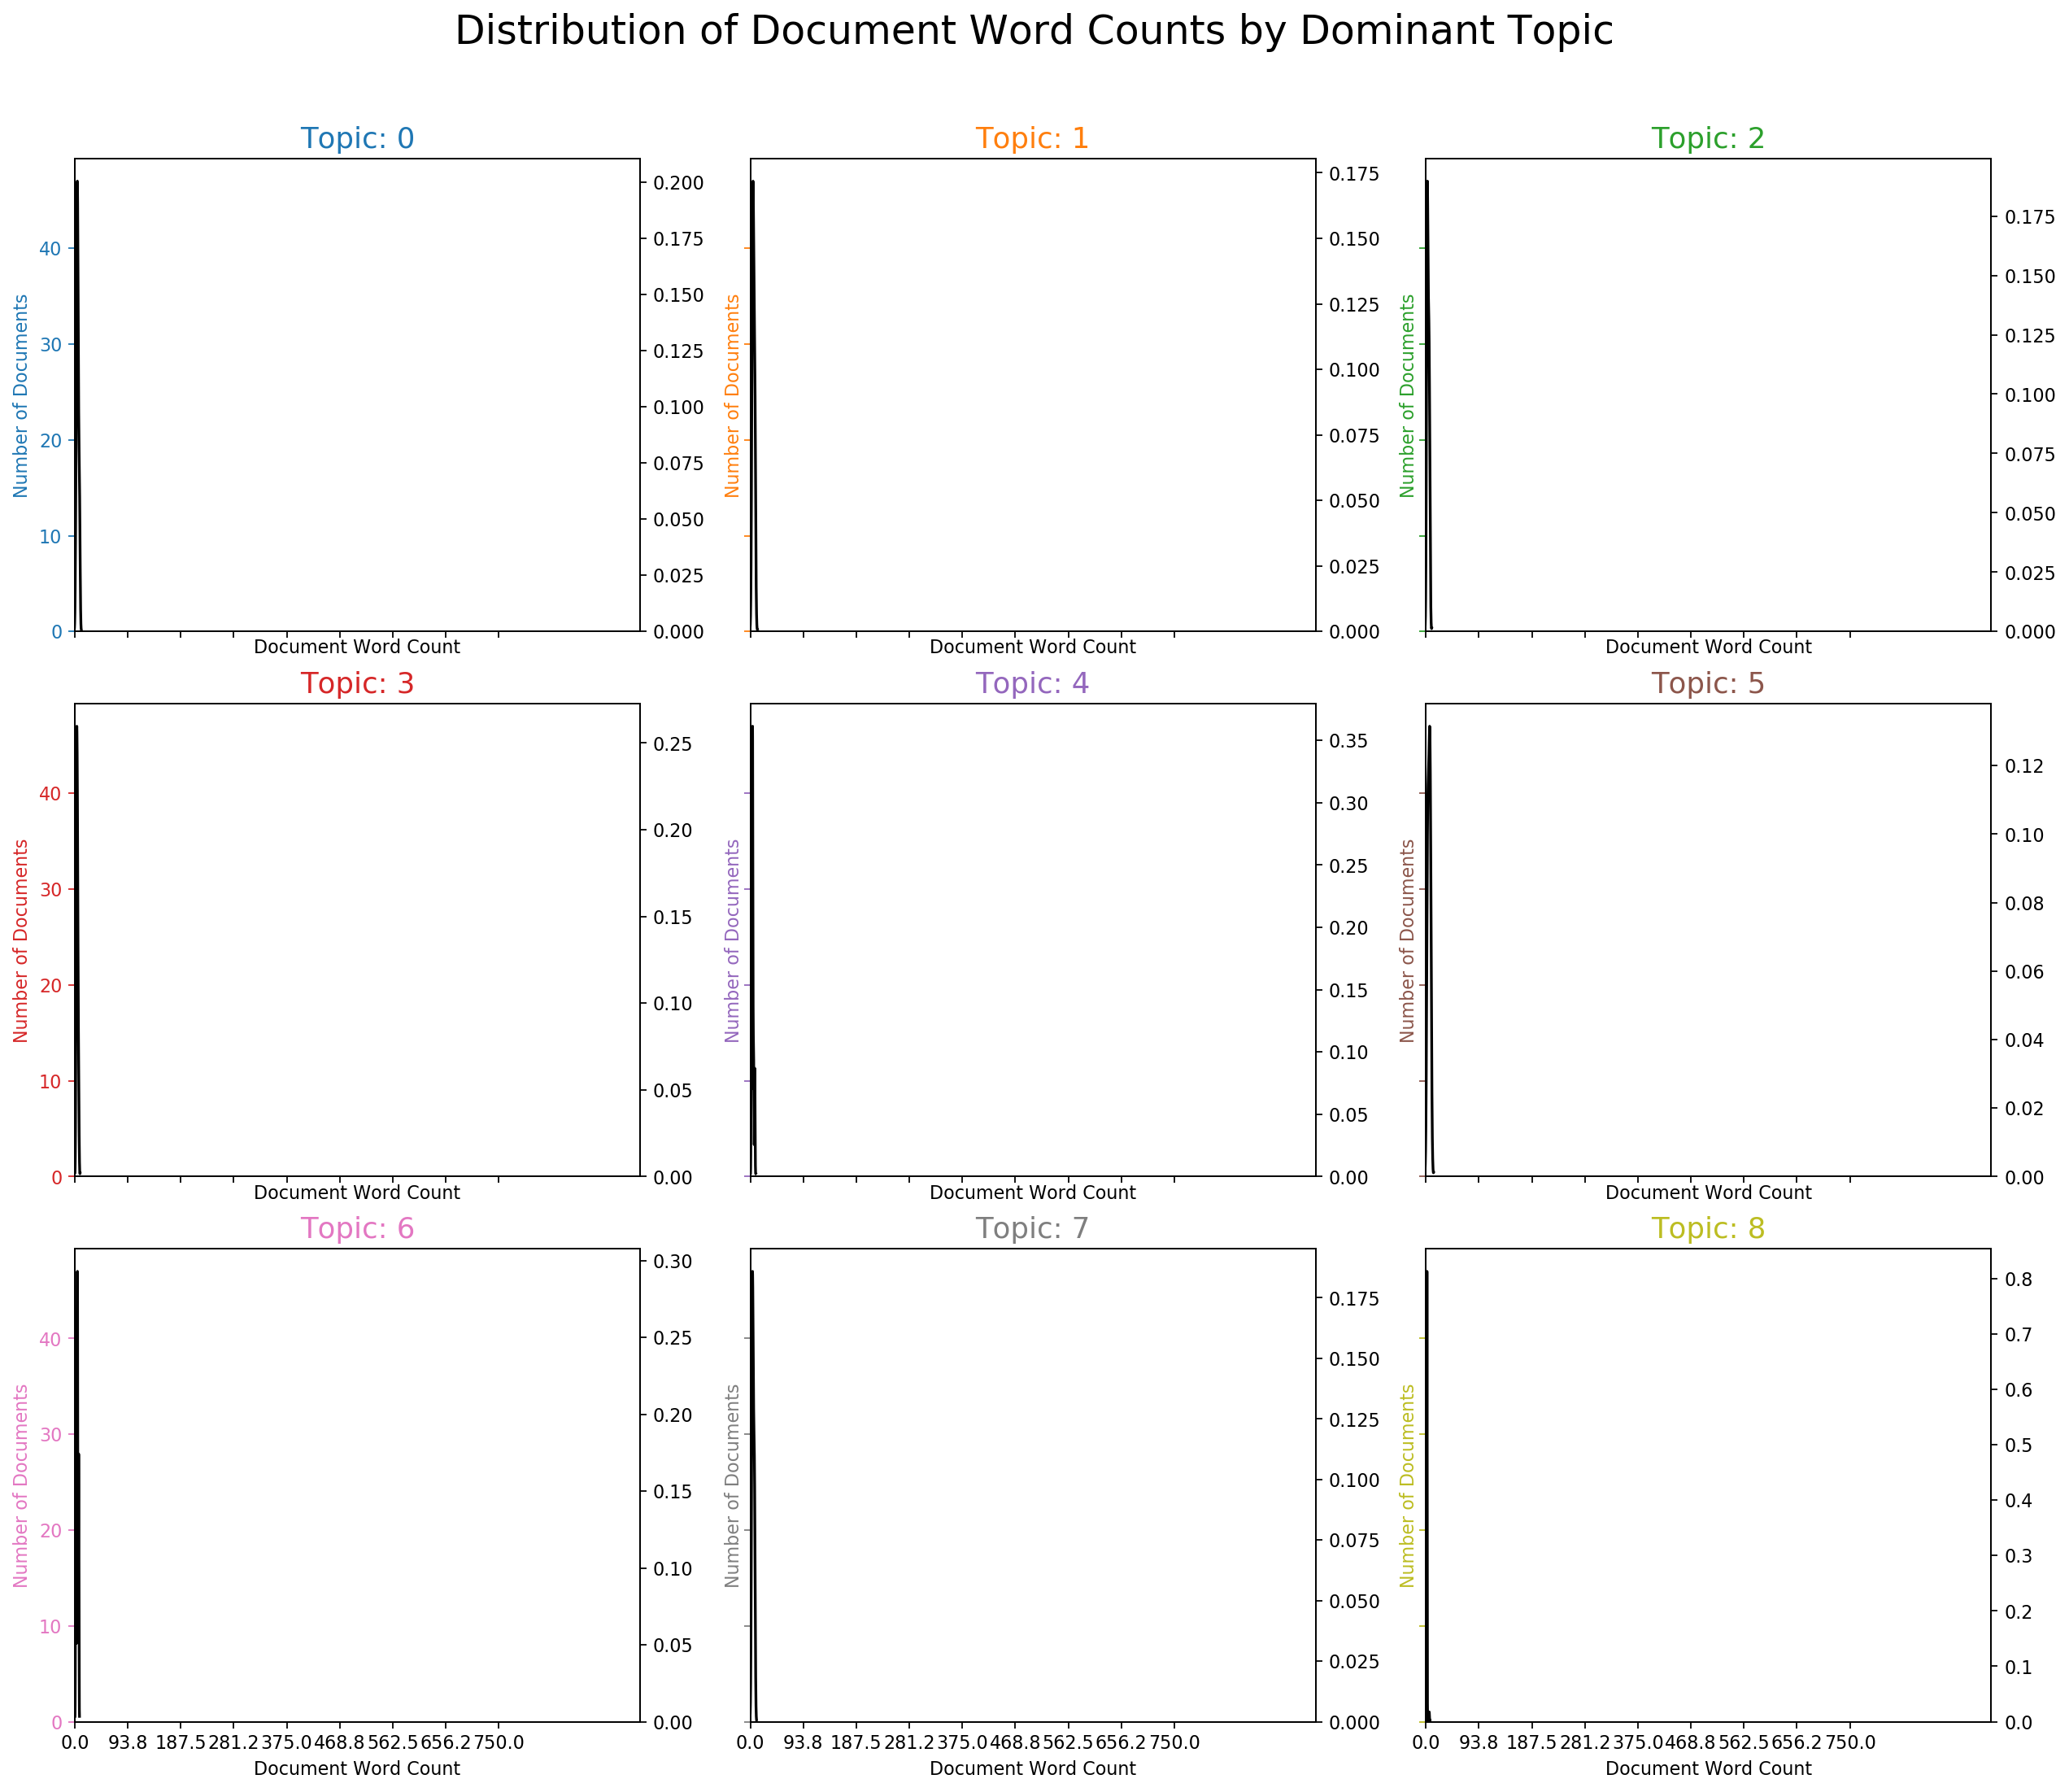

In [146]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 800, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,750,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## 9. Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

In [164]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
len(topics)

10

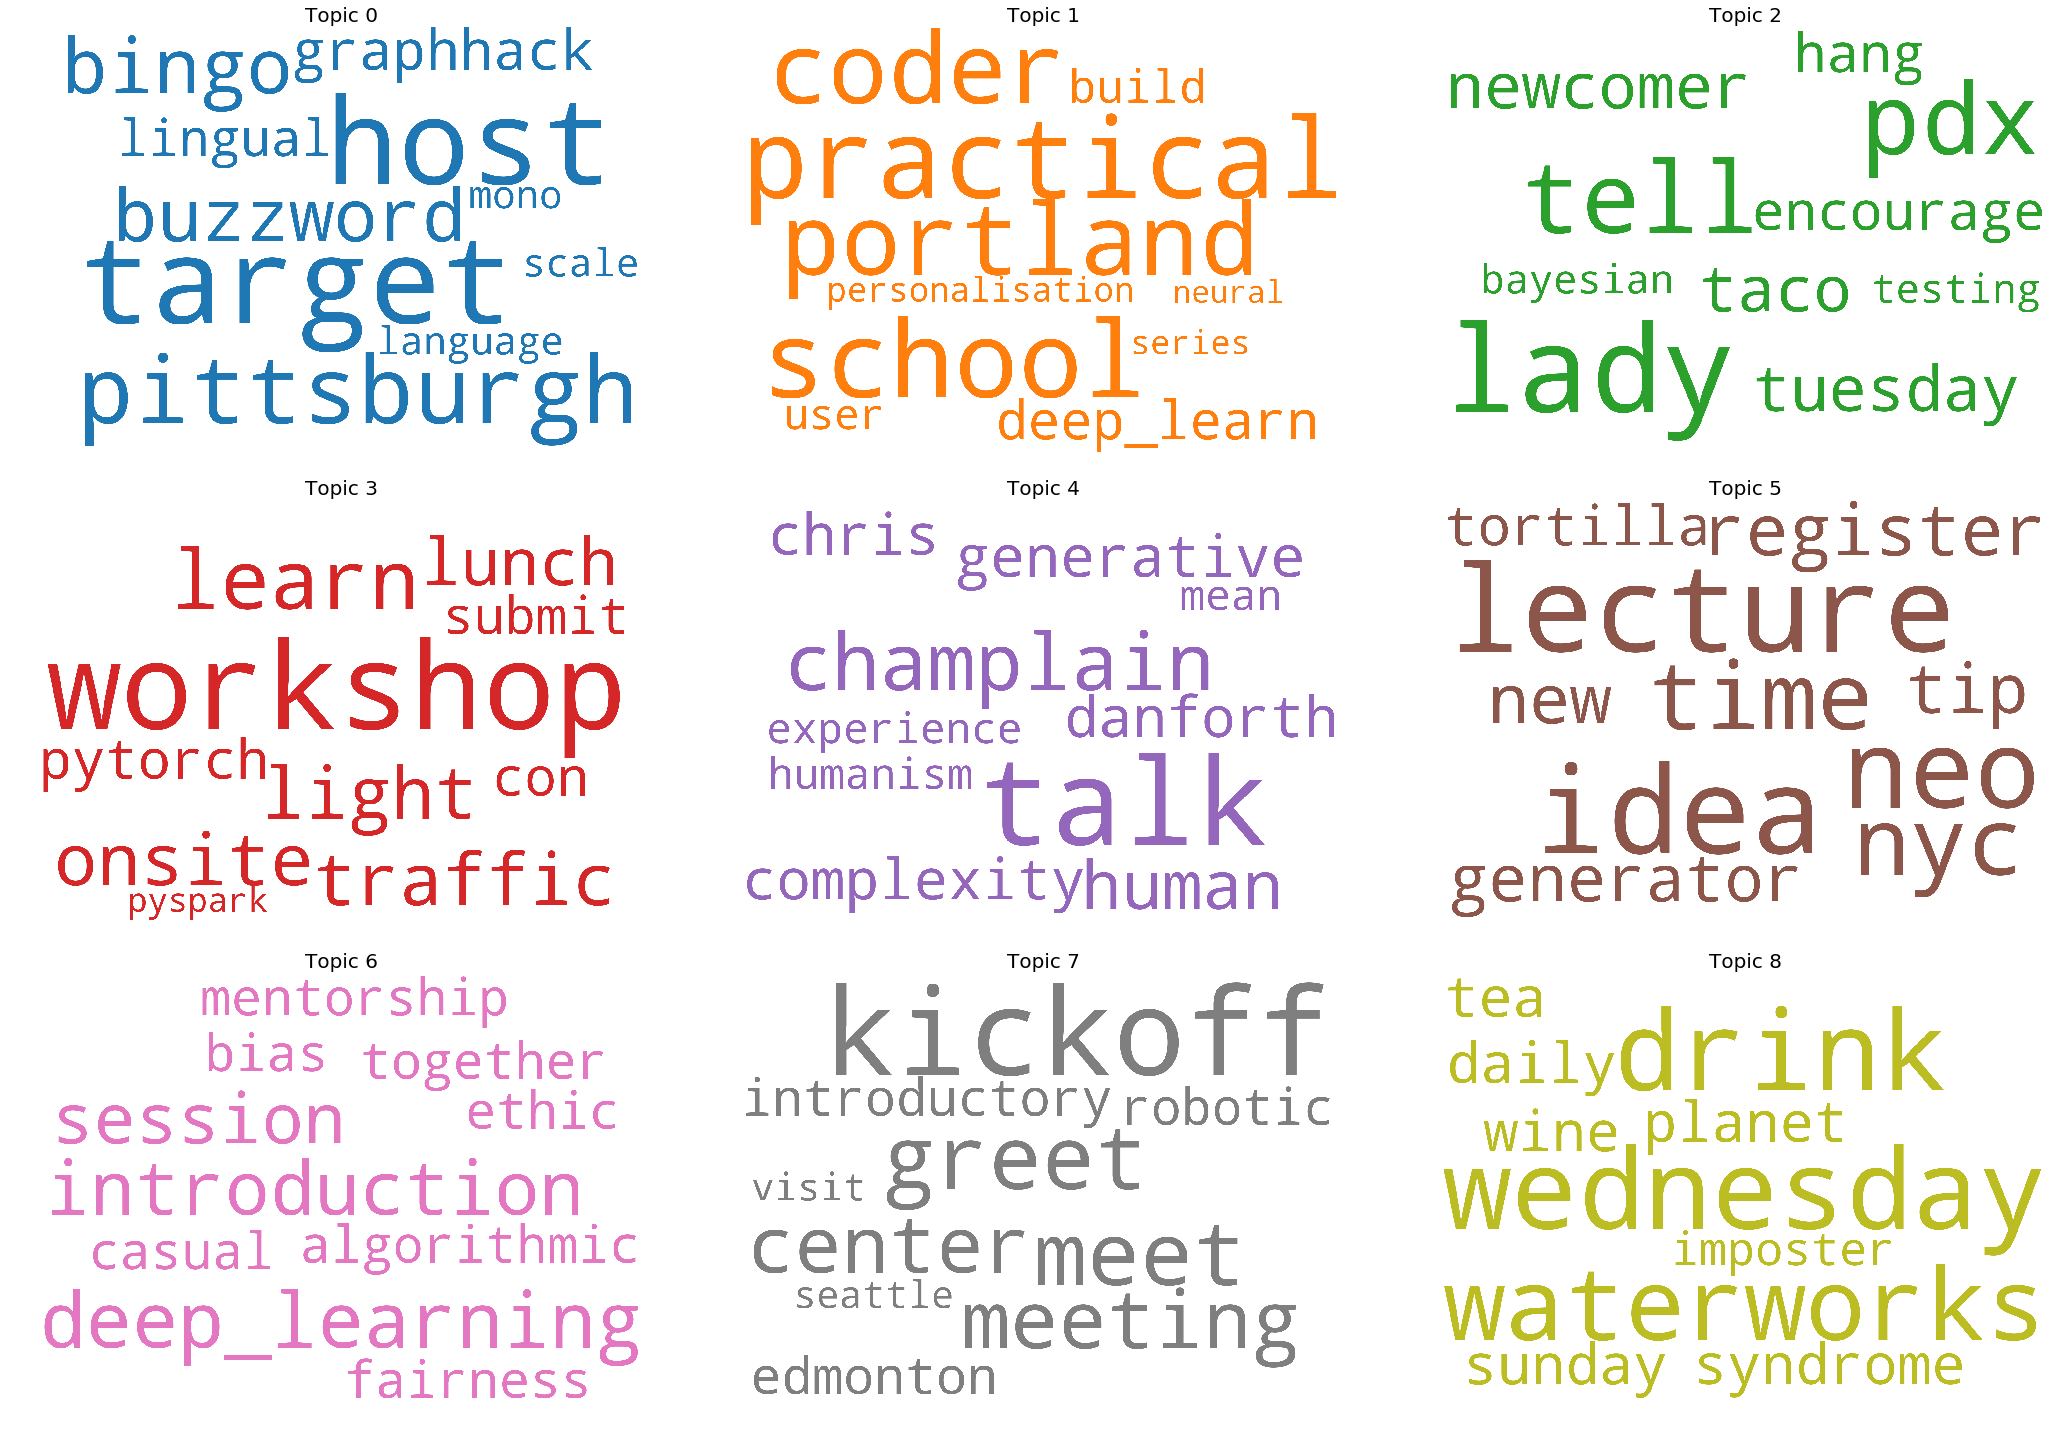

In [181]:
fig, axes = plt.subplots(3, 3, figsize=(30,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

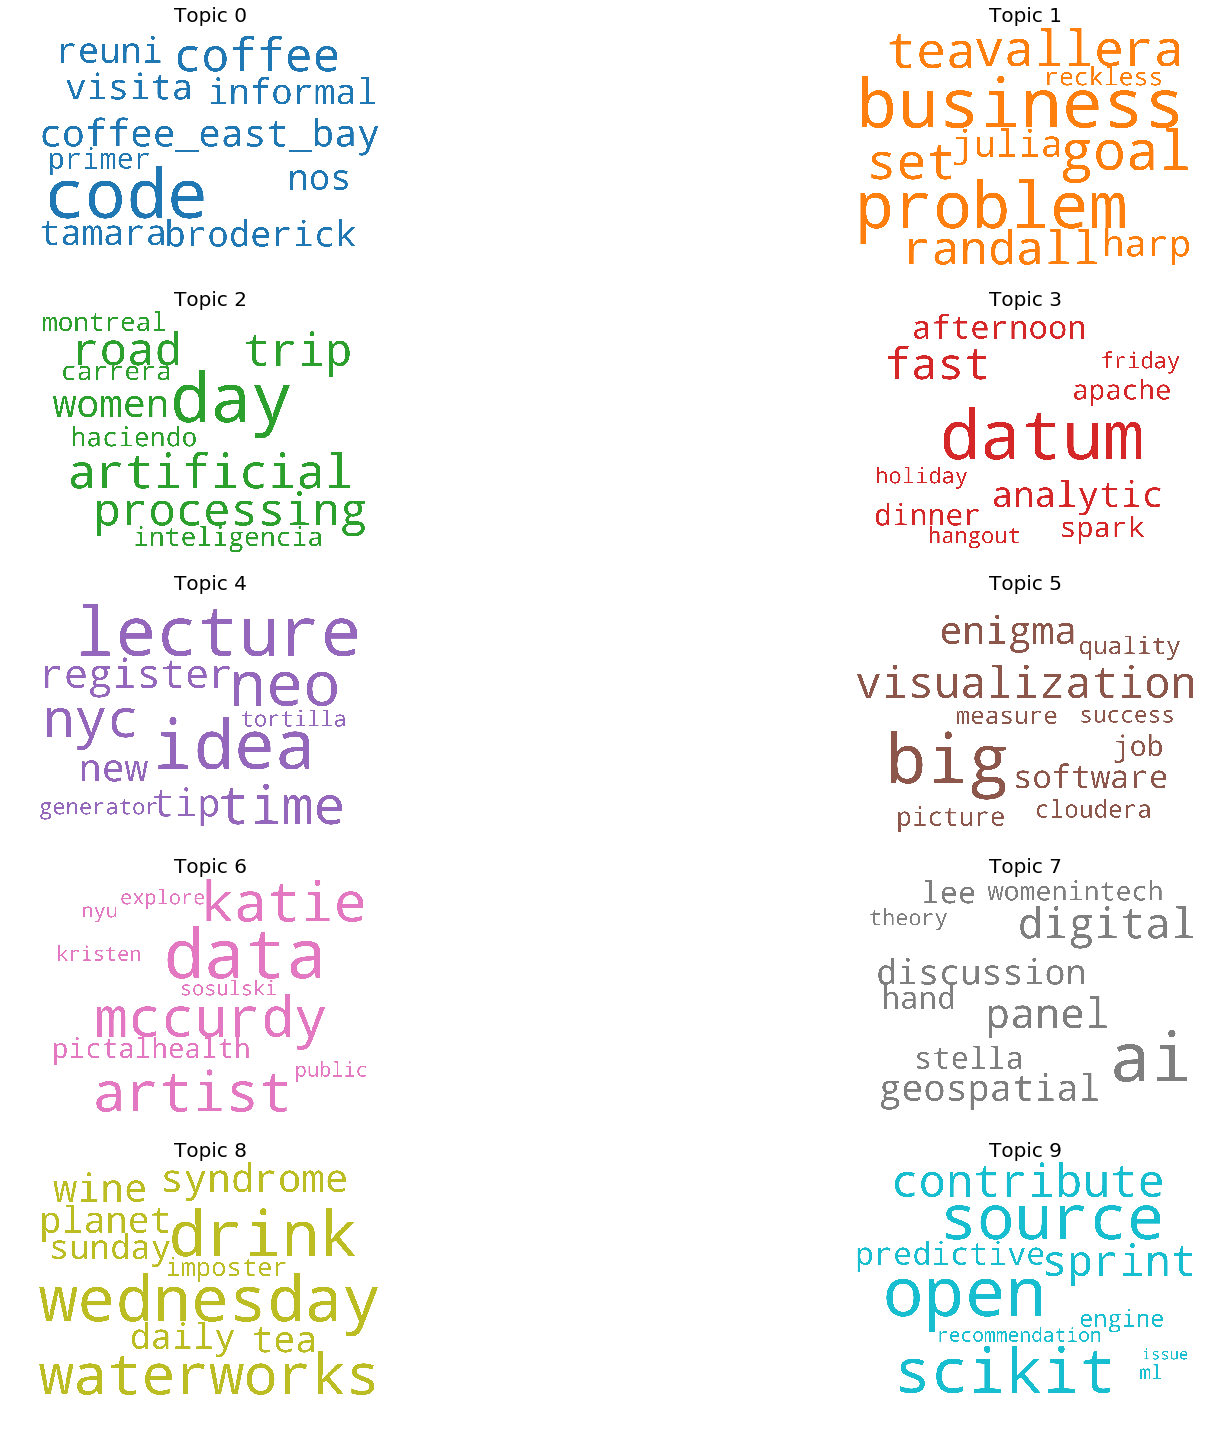

In [165]:
fig, axes = plt.subplots(5, 2, figsize=(30,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## 10. Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.`

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

In [168]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
df.head()

,word,topic_id,importance,word_count
0,target,5,0.053737,2
1,host,5,0.052687,1
2,pittsburgh,5,0.052687,1
3,bingo,5,0.034248,1
4,buzzword,5,0.034248,1


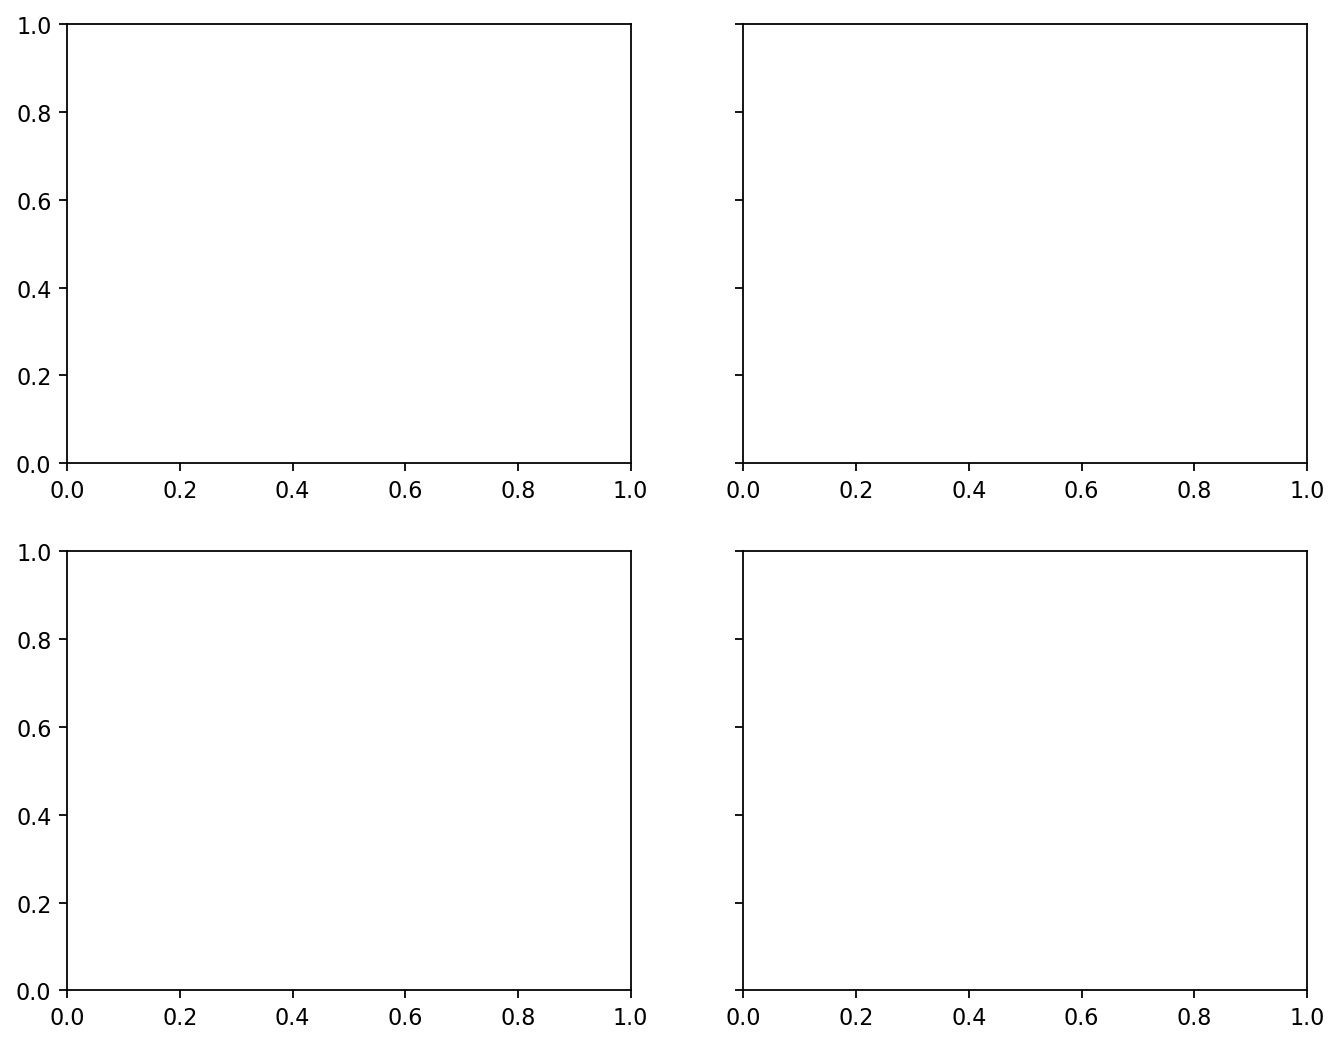

In [173]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

In [175]:
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 300); ax.set_ylim(0, 150)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


IndexError: list index out of range

## 11. Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

IndexError: list index out of range

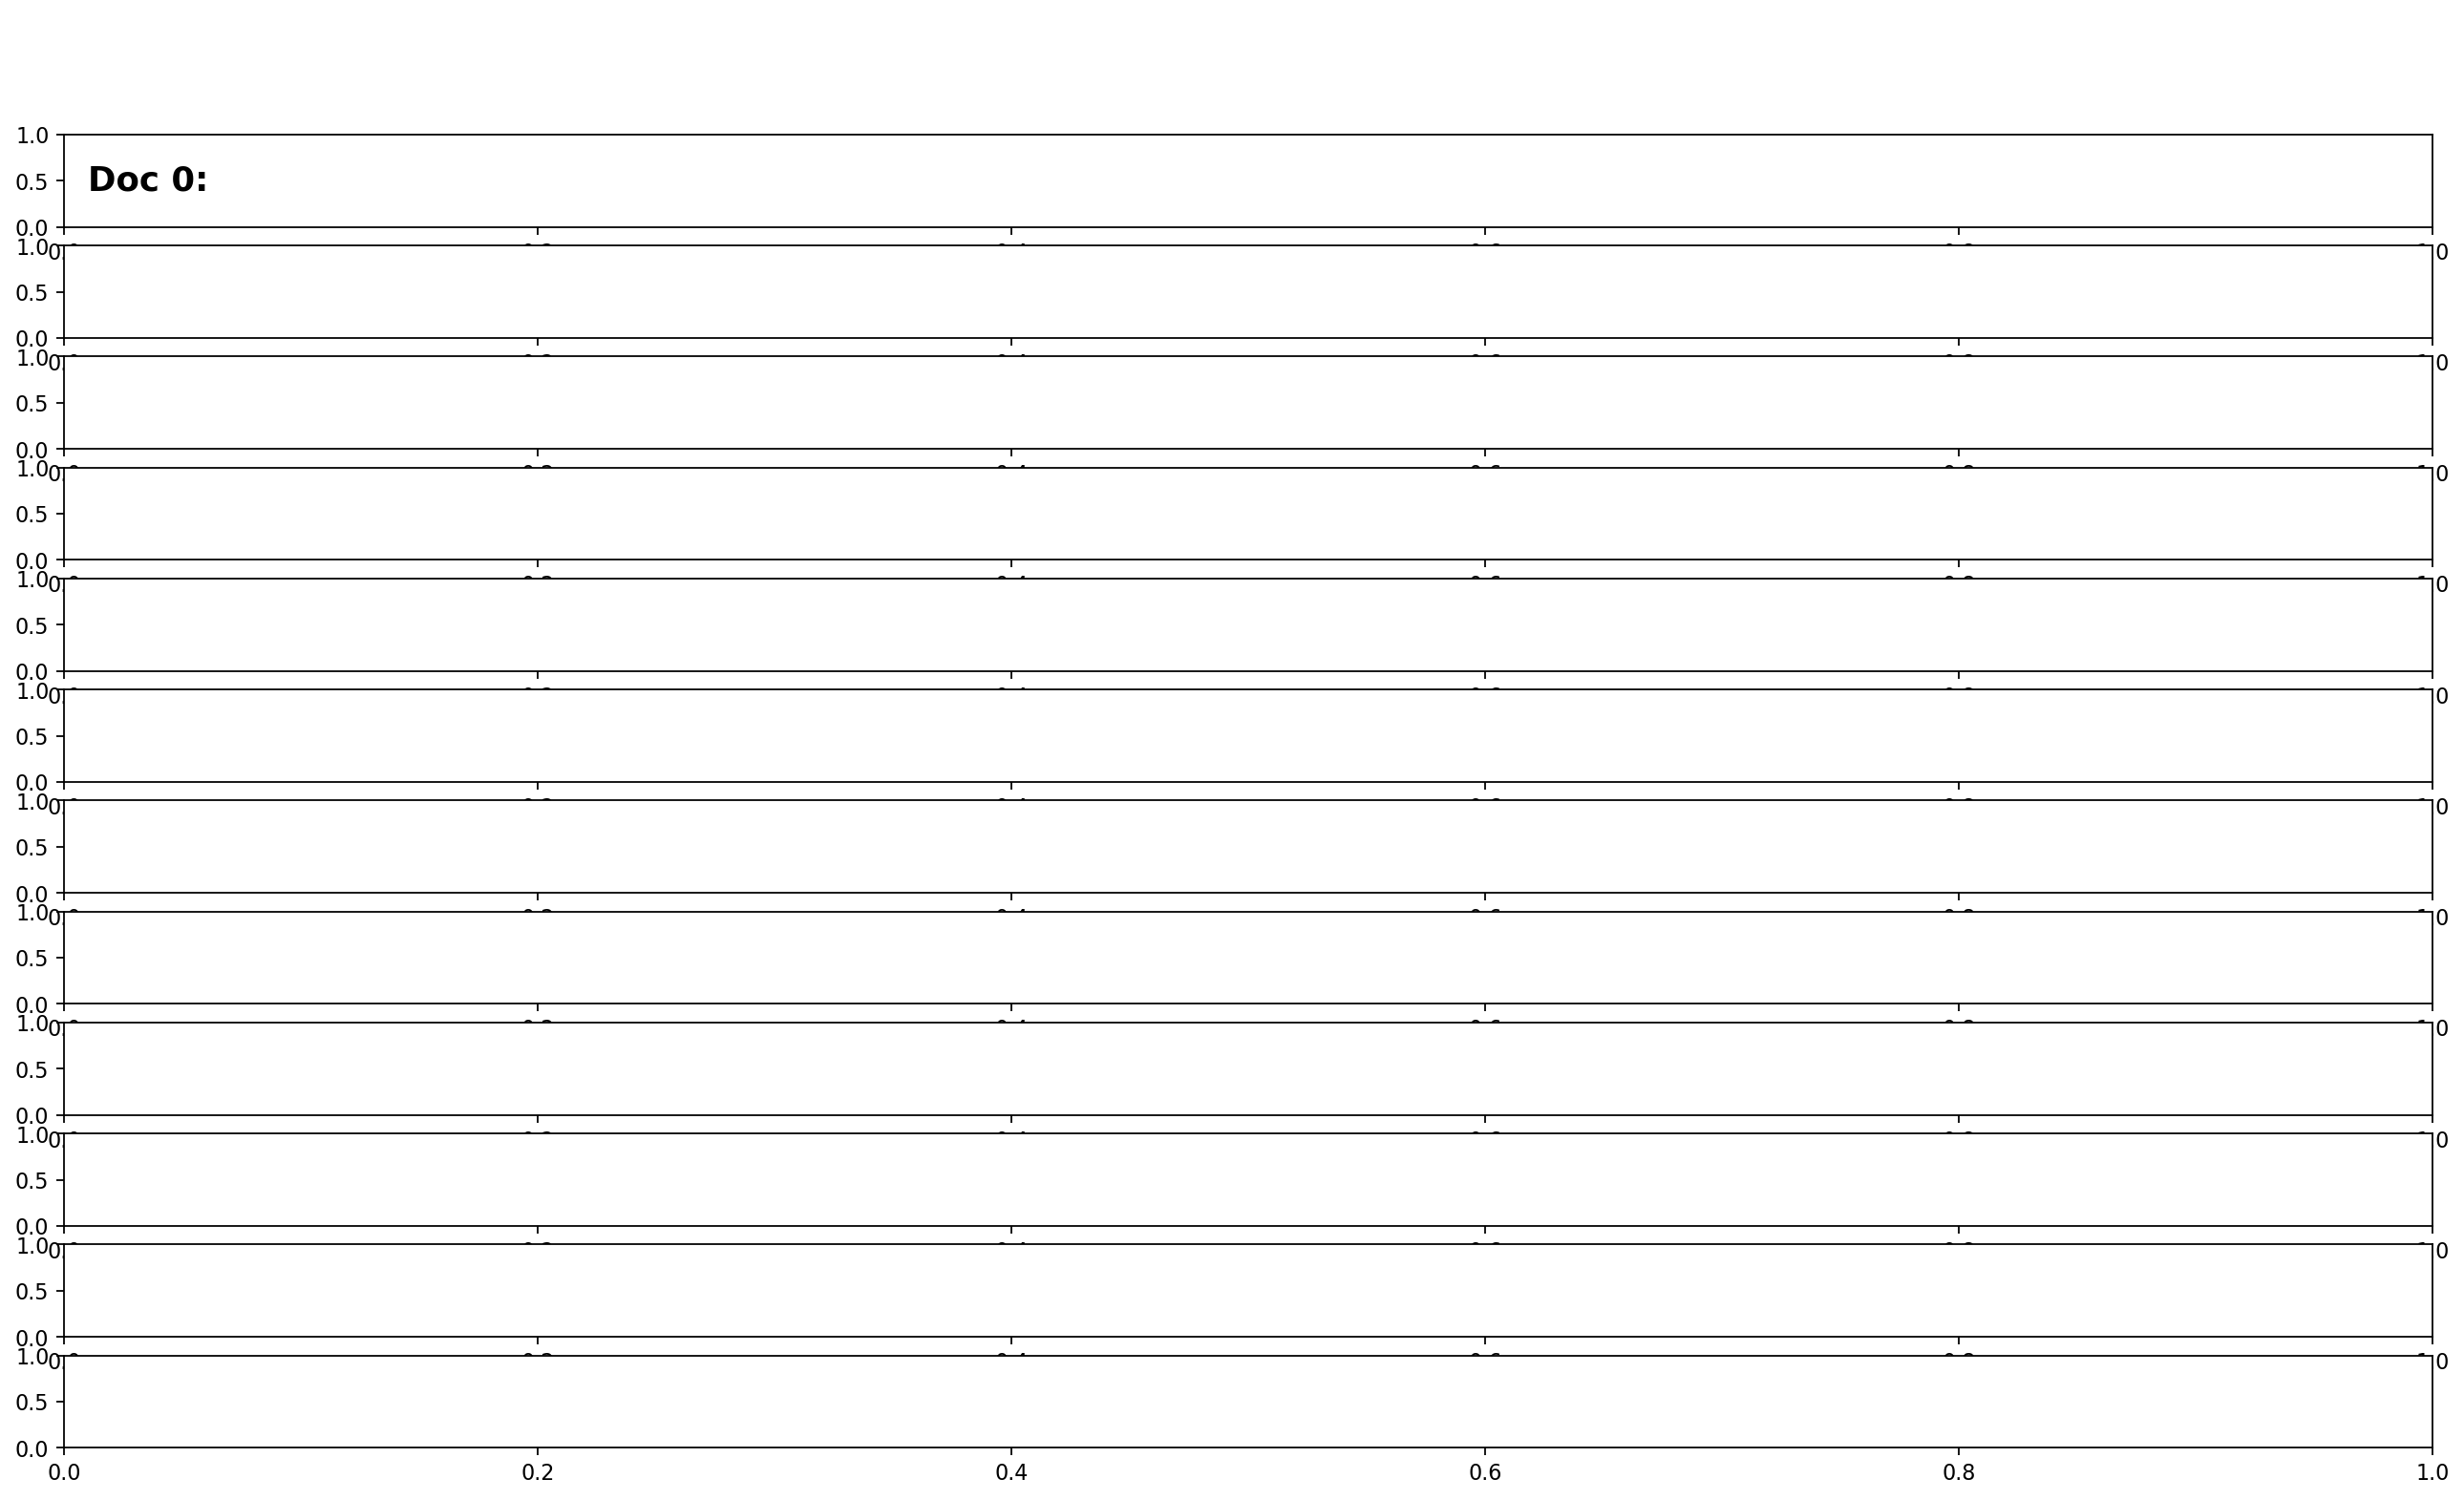

In [176]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## 12. What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.

In [177]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

1. The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
2. The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

In [178]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x480 with 2 Axes>

## 13. t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [179]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 406 samples in 0.008s...
[t-SNE] Computed neighbors for 406 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 406 / 406
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.336082
[t-SNE] Error after 1000 iterations: -2.554610


Loading BokehJS ...

IndexError: index 13 is out of bounds for axis 1 with size 10

## 14. pyLDAVis
Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel().

In [180]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22    -0.337346 -0.216005       1        1  7.414910
10    -0.204773  0.342533       2        1  7.407542
23     0.021868 -0.006896       3        1  6.213364
9     -0.003299 -0.004710       4        1  5.936438
8      0.037681 -0.004398       5        1  5.696355
19    -0.034962 -0.000822       6        1  5.138680
7      0.012432 -0.006765       7        1  4.822586
18    -0.000102 -0.003603       8        1  4.322811
24    -0.005831 -0.004080       9        1  4.159145
1      0.051338 -0.007193      10        1  4.068381
13    -0.015028 -0.013566      11        1  3.999326
15    -0.029315 -0.005394      12        1  3.916030
17     0.017877 -0.005105      13        1  3.586798
3      0.040668 -0.005749      14        1  3.281278
0      0.037788 -0.006875      15        1  3.217930
20     0.053558 -0.003204      16        1  3.152204
16     0.045462 -0.005346      17        1  3.034767
5      0.053976 -0.002629      18        1  2.900188
14     0.010658 -0.011429      19        1  2.829685
11     0.044788 -0.004370      20        1  2.784033
2      0.012248 -0.006332      21        1  2.696328
12     0.053213 -0.002772      22        1  2.617617
6      0.052501 -0.003848      23        1  2.477312
4      0.048448 -0.007116      24        1  2.207949
21     0.036152 -0.004327      25        1  2.118344, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
21    Default  47.000000    data_science  47.000000  30.0000  30.0000
2     Default  32.000000           datum  32.000000  29.0000  29.0000
148   Default  28.000000           woman  28.000000  28.0000  28.0000
6     Default  27.000000   machine_learn  27.000000  27.0000  27.0000
88    Default  20.000000              ai  20.000000  26.0000  26.0000
108   Default  23.000000           wimld  23.000000  25.0000  25.0000
31    Default  17.000000           event  17.000000  24.0000  24.0000
66    Default  17.000000            code  17.000000  23.0000  23.0000
115   Default  14.000000        workshop  14.000000  22.0000  22.0000
96    Default  18.000000          meetup  18.000000  21.0000  21.0000
314   Default  11.000000            talk  11.000000  20.0000  20.0000
97    Default  17.000000          python  17.000000  19.0000  19.0000
132   Default  10.000000             day  10.000000  18.0000  18.0000
63    Default  11.000000      conference  11.000000  17.0000  17.0000
366   Default   9.000000           intro   9.000000  16.0000  16.0000
230   Default   7.000000            lady   7.000000  15.0000  15.0000
292   Default  12.000000           share  12.000000  14.0000  14.0000
276   Default   9.000000          social   9.000000  13.0000  13.0000
222   Default   7.000000         kickoff   7.000000  12.0000  12.0000
219   Default   9.000000            fast   9.000000  11.0000  11.0000
511   Default   8.000000       practical   8.000000  10.0000  10.0000
360   Default   9.000000            tech   9.000000   9.0000   9.0000
605   Default   7.000000         partner   7.000000   8.0000   8.0000
732   Default   7.000000           coder   7.000000   7.0000   7.0000
734   Default   7.000000          school   7.000000   6.0000   6.0000
733   Default   7.000000        portland   7.000000   5.0000   5.0000
0     Default   6.000000             big   6.000000   4.0000   4.0000
245   Default   5.000000  lightning_talk   5.000000   3.0000   3.0000
730   Default   4.000000             pdx   4.000000   2.0000   2.0000
731   Default   4.000000            tell   4.000000   1.0000   1.0000
...       ...        ...             ...        ...      ...      ...
453   Topic25   0.254729           board   0.895394   2.5975  -4.9496
347   Topic25   0.051980             cod   0.692835   1.2646  -6.5390
349   Topic25   0.051980            last   0.692835   1.2646  -6.5390
52    

## 15. Conclusion
We started from scratch by importing, cleaning and processing the newsgroups dataset to build the LDA model. Then we saw multiple ways to visualize the outputs of topic models including the word clouds and sentence coloring, which intuitively tells you what topic is dominant in each topic. A t-SNE clustering and the pyLDAVis are provide more details into the clustering of the topics.

Where next? If you are familiar with [scikit learn](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/), you can build and grid search topic models using scikit learn as well.